Avg= 0.00044403682986740025 0.0008416423108428717 0.0008956099452916532
SD= 5.3622110817232455e-05 7.180548540564917e-05 5.8637004751740025e-05
Best Epoch number is= 1406


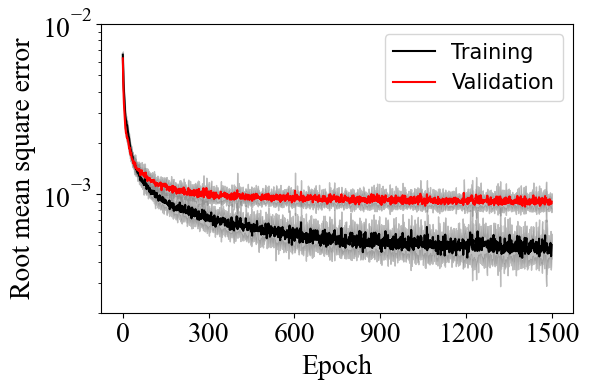

In [1]:
#Note: This code plots Figure 2(a) of the manuscript

import numpy as np
import matplotlib.pyplot as plt
B=np.load("CNN_Accuracy.npy")
A=np.zeros([np.shape(B)[0],4])
C=np.zeros([np.shape(B)[0],4])
kfold=10

for i in range(np.shape(B)[0]):
    A[i][0]=i
    A[i][1]=np.mean(B[i,0:3*kfold:3])
    A[i][2]=np.mean(B[i,1:3*kfold:3])
    A[i][3]=np.mean(B[i,2:3*kfold:3])
    
    C[i][0]=i
    C[i][1]=np.std(B[i,0:3*kfold:3])
    C[i][2]=np.std(B[i,1:3*kfold:3])
    C[i][3]=np.std(B[i,2:3*kfold:3])
plt.figure(figsize=(6, 4))        
plt.plot(A[:,[0]],A[:,[1]],color='black')
plt.fill_between(A[:,0], A[:,1] - C[:,1], A[:,1] + C[:,1], color='gray', alpha=0.5, label='_nolegend_') 
plt.plot(A[:,[0]],A[:,[2]],color='red')
plt.fill_between(A[:,0], A[:,2] - C[:,2], A[:,2] + C[:,2], color='gray', alpha=0.5, label='_nolegend_') 
plt.xlabel('Epoch',fontsize=20, fontname='Times New Roman')
plt.ylabel('Root mean square error',fontsize=20, fontname='Times New Roman')
plt.legend(['Training','Validation'],loc='upper right', fontsize=15, frameon=True)
plt.xticks([0,300,600,900,1200,1500],fontsize=20, fontname='Times New Roman')
print("Avg=",A[np.argmin(A[:,2]),1],A[np.argmin(A[:,2]),2],A[np.argmin(A[:,2]),3]) 
print("SD=",C[np.argmin(A[:,2]),1],C[np.argmin(A[:,2]),2],C[np.argmin(A[:,2]),3])
print('Best Epoch number is=',np.argmin(A[:,2]))
plt.yscale('log')
plt.ylim([2e-4,10e-3])
plt.yticks([1e-3,10e-3],fontsize=20, fontname='Times New Roman') 
plt.tight_layout()
plt.savefig('figure.png', dpi=600)

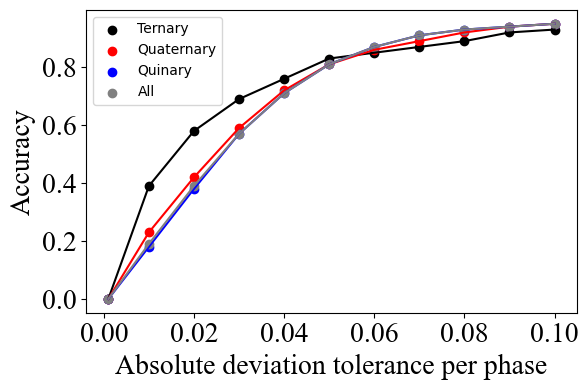

In [2]:
#Note: This code plots Figure 2(b) of the manuscript. Note that m1-m4 values are obtained using the code provided in 
#the next parts

import matplotlib.pyplot as plt
n=[0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
m1=[0,0.39,0.58,0.69,0.76,0.83,0.85,0.87,0.89,0.92,0.93]
m2=[0,0.23,0.42,0.59,0.72,0.81,0.86,0.89,0.92,0.94,0.95]
m3=[0,0.18,0.38,0.57,0.71,0.81,0.87,0.91,0.93,0.94,0.95]
m4=[0,0.19,0.39,0.57,0.71,0.81,0.87,0.91,0.93,0.94,0.95]

plt.figure(figsize=(6, 4))     
plt.scatter(n,m1,color='black',label='Ternary')
plt.plot(n,m1,color='black')

plt.scatter(n,m2,color='red',label='Quaternary')
plt.plot(n,m2,color='red')

plt.scatter(n,m3,color='blue',label='Quinary')
plt.plot(n,m3,color='blue')

plt.scatter(n,m4,color='gray',label='All')
plt.plot(n,m4,color='gray')


plt.xlabel('Absolute deviation tolerance per phase',fontsize=20, fontname='Times New Roman') 
plt.ylabel('Accuracy',fontsize=20, fontname='Times New Roman')
plt.xticks(fontsize=20, fontname='Times New Roman')
plt.yticks(fontsize=20, fontname='Times New Roman')
plt.tight_layout()
plt.legend()
plt.savefig('figure.png', dpi=600)


R2 of all phases are as follows respecitvely: [0.95498562 0.9669326  0.88518478 0.96605187 0.99206989 0.97215579
 0.99012024 0.98955474]


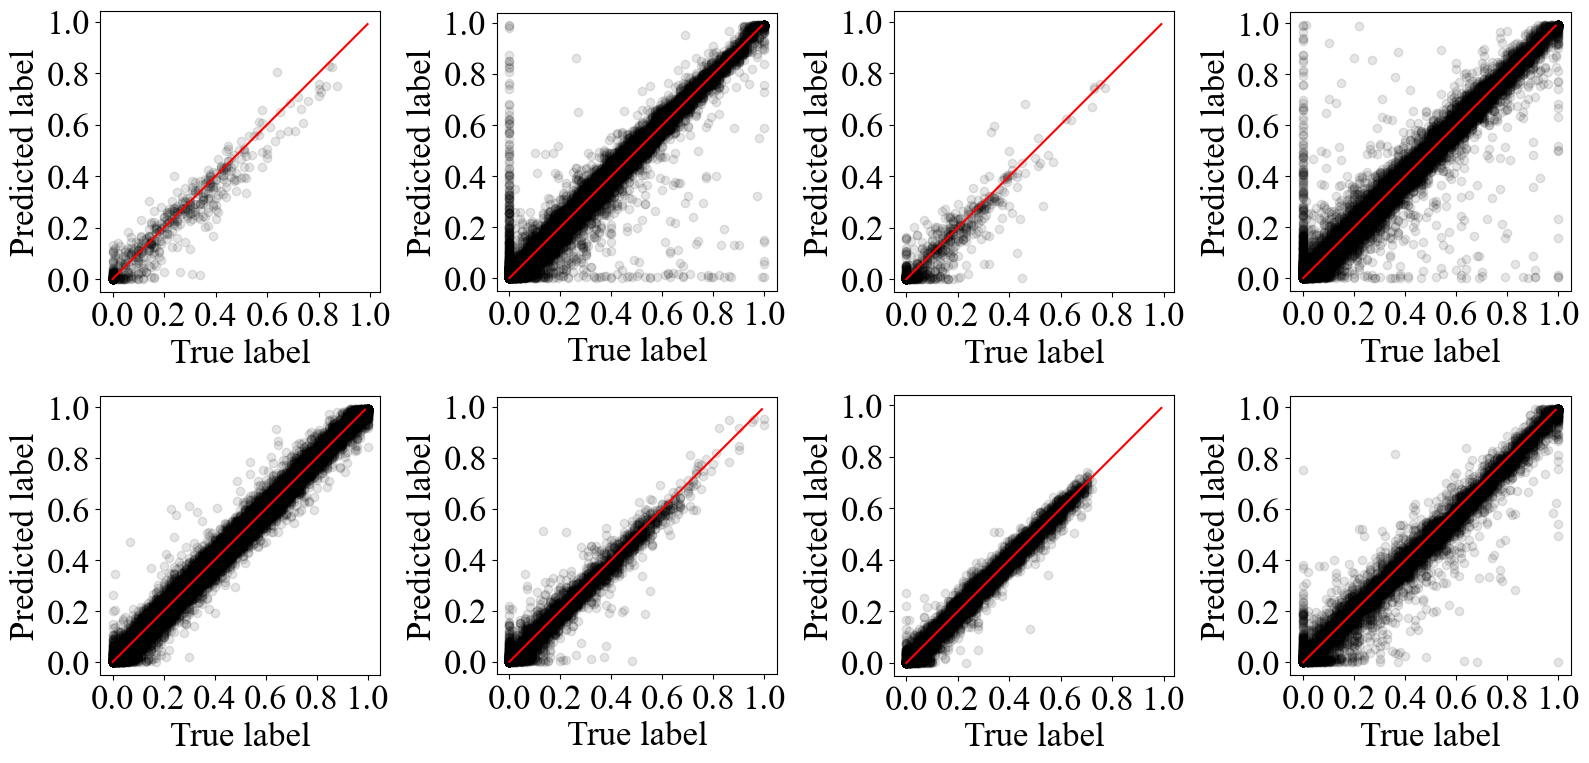

In [12]:
#Note: This code plots Figure 3 of the manuscript.

import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
import time
import numpy as np
import torch
from torch import nn, optim, autograd
from math import pi
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import torch.nn.functional as F


torch.manual_seed(123456)
np.random.seed(123456)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)


class Unit3(nn.Module):
    def __init__(self, in_N, out_N,actf):
        super(Unit3, self).__init__()
        self.in_N = in_N
        self.out_N = out_N
        self.actf = actf
        self.L = nn.Linear(in_N, out_N)

    def forward(self, x):
        actf=self.actf
        x1 = self.L(x)
        if actf==0:
            x2 = torch.tanh(x1)
        elif actf==1:
            x2 = torch.sigmoid(x1) 
        elif actf==2:
            x2 = torch.relu(x1)
        elif actf==3:
            x2 = torch.selu(x1)
        elif actf==4:
            x2 = F.softmax(x1, dim=1)
        return x2
    
class NN3(nn.Module):
    def __init__(self, in_N, width1, depth1,width2, depth2,out_N,bn,dp,dprate,actf):
        super(NN3, self).__init__()
        self.width1 = width1
        self.width2 = width2
        self.depth1 = depth1
        self.depth2 = depth2
        self.bn = bn
        self.dp = dp
        self.dprate = dprate
        self.actf = actf
        self.in_N = in_N
        self.out_N = out_N
        self.stack = nn.ModuleList()
        self.stack.append(Unit3(in_N, width1[0],actf))
        if bn==1:
            self.stack.append(nn.BatchNorm1d(width1[0]))
        for i in range(1,depth1):
            self.stack.append(Unit3(width1[i-1], width1[i],actf))
        
        if dp==1:
            self.stack.append(nn.Dropout(p=dprate))
        if depth2==1:
            self.stack.append(Unit3(width1[i], width2[0],1)) 
        else:
            self.stack.append(Unit3(width1[i], width2[0],actf))    
            for i in range(1,depth2-1):
                self.stack.append(Unit3(width2[i-1], width2[i],actf))
            self.stack.append(Unit3(width2[depth2-2], width2[depth2-1],4)) 
            
    def forward(self, x):
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

activation=0
dropout=1
dropout_rate=0.29791
normalization=1
batch_size=1000
layers1=10
layers2=1
neurons=86
learning_rate=0.00065
L1=[neurons]*layers1
L2=[neurons]*layers2+[8]
model_h = NN3(35,L1,layers1,L2,layers2+1, 8,normalization,dropout,dropout_rate,0)


        
load=1
PATH="checkpoint/model-1406.pt"
if load==1:
    checkpoint = torch.load(PATH)
    model_h.load_state_dict(checkpoint['model_h_state_dict'])
    optimizer2 = optim.AdamW([{'params': model_h.parameters()}], lr=learning_rate) 
    optimizer2.load_state_dict(checkpoint['optimizer2_state_dict'])
    
model_h.eval()
xlo_test=np.load('xlo_test.npy')
ylo_test=np.load('ylo_test.npy')
pred_2h_star_test = model_h(torch.from_numpy(xlo_test).float())

r2_test0 = r2_score(ylo_test[:,0], pred_2h_star_test.detach().numpy()[:,0])
r2_test1 = r2_score(ylo_test[:,1], pred_2h_star_test.detach().numpy()[:,1])
r2_test2 = r2_score(ylo_test[:,2], pred_2h_star_test.detach().numpy()[:,2])
r2_test3 = r2_score(ylo_test[:,3], pred_2h_star_test.detach().numpy()[:,3])
r2_test4 = r2_score(ylo_test[:,4], pred_2h_star_test.detach().numpy()[:,4])
r2_test5 = r2_score(ylo_test[:,5], pred_2h_star_test.detach().numpy()[:,5])
r2_test6 = r2_score(ylo_test[:,6], pred_2h_star_test.detach().numpy()[:,6])
r2_test7 = r2_score(ylo_test[:,7], pred_2h_star_test.detach().numpy()[:,7])
r2_test_final=np.hstack([r2_test0,r2_test1,r2_test2,r2_test3,r2_test4,r2_test5,r2_test6,r2_test7])

import matplotlib.pyplot as plt
import numpy as np

x=np.arange(0,1,0.01)    

fig, axes = plt.subplots(2, 4, figsize=(16, 8), tight_layout=True)

for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.scatter(ylo_test[:, i * 4 + j], pred_2h_star_test.detach().numpy()[:, i * 4 + j], color='black', alpha=0.1)
        ax.plot(x, x, color='red')
        ax.set_xlabel('True label',fontsize=25, fontname='Times New Roman')
        ax.set_ylabel('Predicted label',fontsize=25, fontname='Times New Roman')
        ax.set_aspect('equal')  
        tick_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
        ax.set_xticks(tick_values)
        ax.set_xticklabels(tick_values, fontsize=25, fontname='Times New Roman')
        ax.set_yticks(tick_values)
        ax.set_yticklabels(tick_values, fontsize=25, fontname='Times New Roman')
        
plt.savefig('figure.png', dpi=600)
print('R2 of all phases are as follows respecitvely:',r2_test_final)

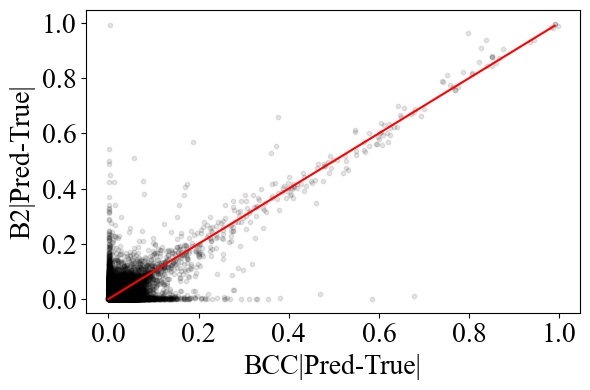

In [13]:
#Note: This code plots the parity plots of Figure 4(a) of the mansucript

import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
import time
import numpy as np
import torch
from torch import nn, optim, autograd
from math import pi
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import torch.nn.functional as F


torch.manual_seed(123456)
np.random.seed(123456)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)


class Unit3(nn.Module):
    def __init__(self, in_N, out_N,actf):
        super(Unit3, self).__init__()
        self.in_N = in_N
        self.out_N = out_N
        self.actf = actf
        self.L = nn.Linear(in_N, out_N)

    def forward(self, x):
        actf=self.actf
        x1 = self.L(x)
        if actf==0:
            x2 = torch.tanh(x1)
        elif actf==1:
            x2 = torch.sigmoid(x1) 
        elif actf==2:
            x2 = torch.relu(x1)
        elif actf==3:
            x2 = torch.selu(x1)
        elif actf==4:
            x2 = F.softmax(x1, dim=1)
        return x2
    
class NN3(nn.Module):
    def __init__(self, in_N, width1, depth1,width2, depth2,out_N,bn,dp,dprate,actf):
        super(NN3, self).__init__()
        self.width1 = width1
        self.width2 = width2
        self.depth1 = depth1
        self.depth2 = depth2
        self.bn = bn
        self.dp = dp
        self.dprate = dprate
        self.actf = actf
        self.in_N = in_N
        self.out_N = out_N
        self.stack = nn.ModuleList()
        self.stack.append(Unit3(in_N, width1[0],actf))
        if bn==1:
            self.stack.append(nn.BatchNorm1d(width1[0]))
        for i in range(1,depth1):
            self.stack.append(Unit3(width1[i-1], width1[i],actf))
        
        if dp==1:
            self.stack.append(nn.Dropout(p=dprate))
        if depth2==1:
            self.stack.append(Unit3(width1[i], width2[0],1)) 
        else:
            self.stack.append(Unit3(width1[i], width2[0],actf))    
            for i in range(1,depth2-1):
                self.stack.append(Unit3(width2[i-1], width2[i],actf))
            self.stack.append(Unit3(width2[depth2-2], width2[depth2-1],4)) 
            
    def forward(self, x):
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

activation=0
dropout=1
dropout_rate=0.29791
normalization=1
batch_size=1000
layers1=10
layers2=1
neurons=86
learning_rate=0.00065
L1=[neurons]*layers1
L2=[neurons]*layers2+[8]
model_h = NN3(35,L1,layers1,L2,layers2+1, 8,normalization,dropout,dropout_rate,0)


        
load=1
PATH="checkpoint/model-1406.pt"
if load==1:
    checkpoint = torch.load(PATH)
    model_h.load_state_dict(checkpoint['model_h_state_dict'])
    optimizer2 = optim.AdamW([{'params': model_h.parameters()}], lr=learning_rate) 
    optimizer2.load_state_dict(checkpoint['optimizer2_state_dict'])
    
model_h.eval()
xlo_test=np.load('xlo_test.npy')
ylo_test=np.load('ylo_test.npy')
pred_2h_star_test = model_h(torch.from_numpy(xlo_test).float())

A=np.zeros([xlo_test.shape[0],8])
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        A[i,j]=np.abs(pred_2h_star_test.detach().numpy()[i,j]-ylo_test[i,j])
        
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))     
plt.scatter(A[:,1],A[:,3],alpha=0.1,s=10,color='black')
x=np.arange(0,1,0.01)
plt.plot(x, x, color='red')
plt.xlabel('BCC|Pred-True|',fontsize=20, fontname='Times New Roman')
plt.ylabel('B2|Pred-True|',fontsize=20, fontname='Times New Roman')
plt.xticks(fontsize=20, fontname='Times New Roman')
plt.yticks(fontsize=20, fontname='Times New Roman')
plt.tight_layout()
plt.savefig('figure.png', dpi=600)

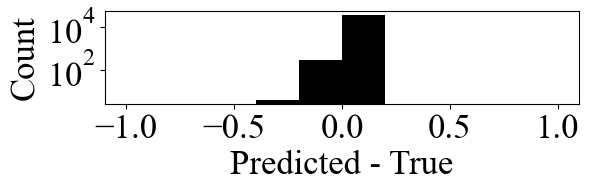

In [5]:
#Note:This code plots the error distribution of Figure 4(a) of the mansucript

phs=0 #FCC=0, BCC=1, HCP=2, B2=3, Laves=4, Sigma=5, Heusler=6, Liquid=7
Z=[]
bin_range = (-1, 1)
bin_size = 0.2
num_bins = int((bin_range[1] - bin_range[0]) / bin_size)
bins = np.arange(bin_range[0], bin_range[1] + bin_size, bin_size)


for i in range(ylo_test.shape[0]):
    err=(pred_2h_star_test.detach().numpy()[i, phs]-ylo_test[i, phs])
    Z=np.append(Z,err)

plt.figure(figsize=(6, 2))     
plt.hist(Z,color='black',bins=bins)
plt.yscale('log') 
plt.xlabel('Predicted - True',fontsize=25, fontname='Times New Roman') 
plt.ylabel('Count',fontsize=25, fontname='Times New Roman')
plt.xticks([-1,-0.5,0,0.5,1], fontsize=25, fontname='Times New Roman')
plt.yticks(fontsize=25, fontname='Times New Roman')
plt.tight_layout()

plt.savefig('figure.png', dpi=600)


In [6]:
#Note: This code is used to obtain the data needed for plotting Figure 4(b) of the mansuciprt in the next part. Also, this 
#Could can be simplified to obtain the data need for plotting Figure 2(b).

import numpy as np    
import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
import time
import numpy as np
import torch
from torch import nn, optim, autograd
from math import pi
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import torch.nn.functional as F


torch.manual_seed(123456)
np.random.seed(123456)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)


class Unit3(nn.Module):
    def __init__(self, in_N, out_N,actf):
        super(Unit3, self).__init__()
        self.in_N = in_N
        self.out_N = out_N
        self.actf = actf
        self.L = nn.Linear(in_N, out_N)

    def forward(self, x):
        actf=self.actf
        x1 = self.L(x)
        if actf==0:
            x2 = torch.tanh(x1)
        elif actf==1:
            x2 = torch.sigmoid(x1) 
        elif actf==2:
            x2 = torch.relu(x1)
        elif actf==3:
            x2 = torch.selu(x1)
        elif actf==4:
            x2 = F.softmax(x1, dim=1)
        return x2
    
class NN3(nn.Module):
    def __init__(self, in_N, width1, depth1,width2, depth2,out_N,bn,dp,dprate,actf):
        super(NN3, self).__init__()
        self.width1 = width1
        self.width2 = width2
        self.depth1 = depth1
        self.depth2 = depth2
        self.bn = bn
        self.dp = dp
        self.dprate = dprate
        self.actf = actf
        self.in_N = in_N
        self.out_N = out_N
        self.stack = nn.ModuleList()
        self.stack.append(Unit3(in_N, width1[0],actf))
        if bn==1:
            self.stack.append(nn.BatchNorm1d(width1[0]))
        for i in range(1,depth1):
            self.stack.append(Unit3(width1[i-1], width1[i],actf))
        
        if dp==1:
            self.stack.append(nn.Dropout(p=dprate))
        if depth2==1:
            self.stack.append(Unit3(width1[i], width2[0],1)) 
        else:
            self.stack.append(Unit3(width1[i], width2[0],actf))    
            for i in range(1,depth2-1):
                self.stack.append(Unit3(width2[i-1], width2[i],actf))
            self.stack.append(Unit3(width2[depth2-2], width2[depth2-1],4)) 
            
    def forward(self, x):
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

activation=0
dropout=1
dropout_rate=0.29791
normalization=1
batch_size=1000
layers1=10
layers2=1
neurons=86
learning_rate=0.00065
L1=[neurons]*layers1
L2=[neurons]*layers2+[8]
model_h = NN3(35,L1,layers1,L2,layers2+1, 8,normalization,dropout,dropout_rate,0)    
load=1
PATH="checkpoint/model-1406.pt"
if load==1:
    checkpoint = torch.load(PATH)
    model_h.load_state_dict(checkpoint['model_h_state_dict'])
    optimizer2 = optim.AdamW([{'params': model_h.parameters()}], lr=learning_rate) 
    optimizer2.load_state_dict(checkpoint['optimizer2_state_dict'])    
model_h.eval()

x=np.load('xlo_test.npy')
y=np.load('ylo_test.npy')
T=[]
for i in range(x.shape[0]):
    T=np.append(T,(x[i,-1]*(1891-850))+850)
X=np.zeros([0,35])
Y=np.zeros([0,8])
for i in range(T.shape[0]):
    if T[i]<1050: #desired T interval
        X=np.append(X,x[[i],:],axis=0)
        Y=np.append(Y,y[[i],:],axis=0)

A=np.copy(Y)        
pred_2h_star_test= model_h(torch.from_numpy(X).float())
B=pred_2h_star_test.detach().numpy()[:, :]


m=0
for i in range(B.shape[0]):
    n=0
    for j in range(B.shape[1]):
        if np.abs(B[i,j]-A[i,j])>0.07: #Threshold
            n=1
    if n==0:
        m=m+1
print('The accuracy corresponding to the chosen absolute deviation tolerance per phase=',m/B.shape[0])

The accuracy corresponding to the chosen absolute deviation tolerance per phase= 0.9187861778635327


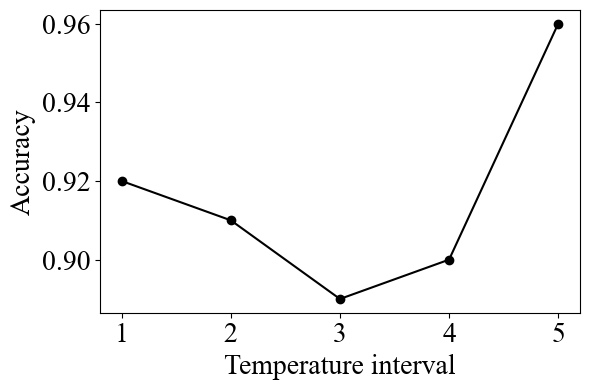

In [7]:
#Note: This code plot Figure 4(b) of the manusciprt

import matplotlib.pyplot as plt
n=[1,2,3,4,5]
m=[0.92,0.91,0.89,0.90,0.96]

plt.figure(figsize=(6, 4))     
plt.scatter(n,m,color='black')
plt.plot(n,m,color='black')
plt.xlabel('Temperature interval',fontsize=20, fontname='Times New Roman') 
plt.ylabel('Accuracy',fontsize=20, fontname='Times New Roman')
plt.xticks([1,2,3,4,5],fontsize=20, fontname='Times New Roman')
plt.yticks([0.90,0.92,0.94,0.96],fontsize=20, fontname='Times New Roman')
plt.tight_layout()
plt.savefig('figure.png', dpi=600)

In [8]:
#Note: This code is used to prepare Table 1 of the manuscript

import numpy as np    
import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
import time
import numpy as np
import torch
from torch import nn, optim, autograd
from math import pi
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
import torch.nn.functional as F


torch.manual_seed(123456)
np.random.seed(123456)


def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)


class Unit3(nn.Module):
    def __init__(self, in_N, out_N,actf):
        super(Unit3, self).__init__()
        self.in_N = in_N
        self.out_N = out_N
        self.actf = actf
        self.L = nn.Linear(in_N, out_N)

    def forward(self, x):
        actf=self.actf
        x1 = self.L(x)
        if actf==0:
            x2 = torch.tanh(x1)
        elif actf==1:
            x2 = torch.sigmoid(x1) 
        elif actf==2:
            x2 = torch.relu(x1)
        elif actf==3:
            x2 = torch.selu(x1)
        elif actf==4:
            x2 = F.softmax(x1, dim=1)
        return x2
    
class NN3(nn.Module):
    def __init__(self, in_N, width1, depth1,width2, depth2,out_N,bn,dp,dprate,actf):
        super(NN3, self).__init__()
        self.width1 = width1
        self.width2 = width2
        self.depth1 = depth1
        self.depth2 = depth2
        self.bn = bn
        self.dp = dp
        self.dprate = dprate
        self.actf = actf
        self.in_N = in_N
        self.out_N = out_N
        self.stack = nn.ModuleList()
        self.stack.append(Unit3(in_N, width1[0],actf))
        if bn==1:
            self.stack.append(nn.BatchNorm1d(width1[0]))
        for i in range(1,depth1):
            self.stack.append(Unit3(width1[i-1], width1[i],actf))
        
        if dp==1:
            self.stack.append(nn.Dropout(p=dprate))
        if depth2==1:
            self.stack.append(Unit3(width1[i], width2[0],1)) 
        else:
            self.stack.append(Unit3(width1[i], width2[0],actf))    
            for i in range(1,depth2-1):
                self.stack.append(Unit3(width2[i-1], width2[i],actf))
            self.stack.append(Unit3(width2[depth2-2], width2[depth2-1],4)) 
            
    def forward(self, x):
        for i in range(len(self.stack)):
            x = self.stack[i](x)
        return x

activation=0
dropout=1
dropout_rate=0.29791
normalization=1
batch_size=1000
layers1=10
layers2=1
neurons=86
learning_rate=0.00065
L1=[neurons]*layers1
L2=[neurons]*layers2+[8]
model_h = NN3(35,L1,layers1,L2,layers2+1, 8,normalization,dropout,dropout_rate,0)


      
load=1
PATH="checkpoint/model-1406.pt"
if load==1:
    checkpoint = torch.load(PATH)
    model_h.load_state_dict(checkpoint['model_h_state_dict'])
    optimizer2 = optim.AdamW([{'params': model_h.parameters()}], lr=learning_rate) 
    optimizer2.load_state_dict(checkpoint['optimizer2_state_dict'])
    
model_h.eval()

x=np.load('xlo_test.npy')
y=np.load('ylo_test.npy')
T=[]
for i in range(x.shape[0]):
    T=np.append(T,(x[i,-1]*(1891-850))+850)
X=np.zeros([0,35])
Y=np.zeros([0,8])
for i in range(T.shape[0]):
    if T[i]<1050: #desired T interval
        X=np.append(X,x[[i],:],axis=0)
        Y=np.append(Y,y[[i],:],axis=0)
        
pred_2h_star_test = model_h(torch.from_numpy(X).float())
r2_test0 = r2_score(Y[:,0], pred_2h_star_test.detach().numpy()[:,0]) 
r2_test1 = r2_score(Y[:,1], pred_2h_star_test.detach().numpy()[:,1]) 
r2_test2 = r2_score(Y[:,2], pred_2h_star_test.detach().numpy()[:,2]) 
r2_test3 = r2_score(Y[:,3], pred_2h_star_test.detach().numpy()[:,3]) 
r2_test4 = r2_score(Y[:,4], pred_2h_star_test.detach().numpy()[:,4]) 
r2_test5 = r2_score(Y[:,5], pred_2h_star_test.detach().numpy()[:,5]) 
r2_test6 = r2_score(Y[:,6], pred_2h_star_test.detach().numpy()[:,6]) 
r2_test7 = r2_score(Y[:,7], pred_2h_star_test.detach().numpy()[:,7]) 
r2_test_final=np.hstack([r2_test0,r2_test1,r2_test2,r2_test3,r2_test4,r2_test5,r2_test6,r2_test7])
print('R2 of all phases for the chosen interval is=',r2_test_final)

R2 of all phases for the chosen interval is= [0.96215124 0.95937407 0.89112926 0.97027698 0.99162105 0.97801235
 0.99281724 0.95469722]


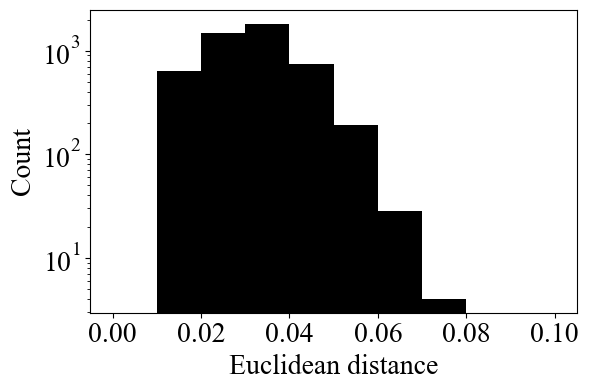

In [9]:
#Note: This code is used to plot Supplementary Figure S1 of the manuscript.

from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np


nn_model = NearestNeighbors(n_neighbors=1, algorithm='auto', n_jobs=-1)
train_comps = np.load('xlo_850K_comp.npy')[:,:]
test_comps = np.load('xlo_test_850K_comp.npy')[:,:]
nn_model.fit(train_comps) 
distances1, indices1 = nn_model.kneighbors(test_comps) 

bin_range = (0, 0.1)
bin_size = 0.01
num_bins = int((bin_range[1] - bin_range[0]) / bin_size)
bins = np.arange(bin_range[0], bin_range[1] + bin_size, bin_size)

plt.figure(figsize=(6, 4))     
plt.hist(distances1,color='black',bins=bins)
plt.yscale('log')
plt.xlabel('Euclidean distance',fontsize=20, fontname='Times New Roman') 
plt.ylabel('Count',fontsize=20, fontname='Times New Roman')
plt.xticks(fontsize=20, fontname='Times New Roman')
plt.yticks(fontsize=20, fontname='Times New Roman') 
plt.tight_layout()
plt.savefig('figure.png', dpi=600)